### SENTIMENT ANALYSIS ON IGBO DATA

### Objective

- Build a model that can classify sentiments on news articles as positive, neutral or negative.

### Data

The data was gotten from the NaijaSenti's manually annotated Igbo tweets found <a href = "https://github.com/hausanlp/NaijaSenti/tree/main"> here </a>.

In [202]:
# uncomment the code below to install wordcloud
#!pip install wordcloud
#!pip install emoji
#!pip install sentence-transformers


  Attempting uninstall: sentence-transformers
    Found existing installation: sentence-transformers 3.4.1
    Uninstalling sentence-transformers-3.4.1:
      Successfully uninstalled sentence-transformers-3.4.1


In [314]:
# import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import re
import string
import emoji
import requests
from bs4 import BeautifulSoup
from sklearn.feature_extraction.text import TfidfVectorizer, ENGLISH_STOP_WORDS
from wordcloud import WordCloud #ensure wordcloud is installed
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import GridSearchCV
import nltk

%matplotlib inline

In [94]:
# load data
data1 = pd.read_csv("data/train.tsv", delimiter='\t')
data2 = pd.read_csv("data/dev.tsv", delimiter='\t')

data = pd.concat([data1, data2])
data.sample(5)

,tweet,label
2674,Ọ gịnị zi mere anyị adịghị e mezi nwanne?,neutral
4455,"imegheri a ahu okwu, isi ka I hapu imegheri ah...",neutral
7572,@user @user Ife dị mma 👍,positive
762,@user ibu nwannem nke kpuuu???,neutral
1956,@user @user @user Ndị Lagos na ọnụ ọjọọ ha 🤣🤣🤣,negative


### Data Wrangling and Preprocessing

In [23]:
data.shape

(12033, 2)

In [25]:
# check distribution of sentiments
data["label"].value_counts()

label
neutral     5319
positive    3644
negative    3070
Name: count, dtype: int64

In [27]:
# checking for missing values
data.isnull().sum()

tweet    0
label    0
dtype: int64

In [96]:
def clean(data,column):

  # save the pattern for the punctuation and special characters in regex
  re_punc = re.compile('[%s]' % re.escape(string.punctuation))

  # Replace emojis with text
  #data['clean_tweet'] = data['clean_tweet'].apply(lambda x: emoji.demojize(x, delimiters=(' ', ' '), language='en'))

  # replace the punctuation with nothing for each word in the list
  # and join the words back into a string
  data[column] = data[column].apply(lambda x: ' '.join([re_punc.sub('', word) for word in x.split()]))

  # remove extra special characters not handled above
  data[column] = data[column].apply(lambda x: ' '.join([re.sub(r'[’,-, @]','', word) for word in x.split()]))

  # remove links
  data[column] = data[column].apply(lambda x: ' '.join([re.sub(r'http\S+|www.\S+', '', word) for word in x.split()]))

  # remove html tags
  data[column] = data[column].apply(lambda x: ' '.join([re.sub(r"<.*?>", '', word) for word in x.split()])) 
    
  # remove extra whitspace
  data[column] = data[column].apply(lambda x: x.strip())

  # lower case
  data[column] = data[column].apply(lambda x: x.lower())
    
  print("Data successfully cleaned!")


  return data[column]

In [98]:
data['clean_tweet'] = clean(data, 'tweet')
data['clean_tweet'].sample(10)

Data successfully cleaned!


330                                 user hapụ ndị ara ahụ
6510       user odogwu ma ná si gbapụ ọsọ nọ oge 🏃🏃🏃 biko
8510           user user ebele ihe dị mma na adị m mma na
6716              o so gi o wee gi iwe o so ndi o wee ndi
6413                             o ihe o ji ala ebe di ya
8686                                  oge chukwu kan ma 🙏
5294                  user user na aru onye bikonu 🙆🏽‍♀️😒
167                      user nwa ibiakwa nke ne ese okwu
238                user user user user zuo ike akwuna ọkụ
736     ha nwere nzuko nzuzo amaram twitter ndi igbo b...
Name: clean_tweet, dtype: object

In [102]:
from collections import defaultdict

# Initialize a defaultdict with integer values to store word frequencies
vocab = defaultdict(int)

corpus = data["clean_tweet"]

# Loop through each sentence in the corpus and count no. of occurrence of each word
for article in corpus.apply(lambda x: x.split()):
    for word in article:
        vocab[word] += 1

# Convert the defaultdict vocab to a regular dictionary for easier handling and sorting
# and sort the dictionary by word frequency in descending order
sorted_vocab = dict(sorted(vocab.items(), key=lambda x: x[1], reverse=True))

# Display the sorted vocabulary with each word and its frequency count
#print("Vocabulary with Frequencies:", sorted_vocab)

In [116]:
#  remove stopwords
IGBO_STOPWORDS = {
    "ihe",
    "na",
    "nke",
    "mana",
    "n’",
    "ka",
    "ma",
    "ya",
    "si",
    "ga",
    "di",
    "onye",
    "ndị",
    "bụ",
    "ọ",
    "a",
    "e",
    "i",
    "ị",
    "o",
    "ha",
    "unu",
    "anyị",
    "anyi",
    "gi"
    "gị",
    "m",
    "mụ",
    "bụ",
    "bu",
    "ọ bụla",
    "ọbụna",
    "gịnị",
    "ebee",
    "olee",
    "ole",
    "ahụ",
    "kedụ",
    "maka",
    "mụ onwe m",
    "onwe m",
    "gị onwe gị",
    "onwe gị",
    "ya onwe ya",
    "onwe ya",
    "anyị onwe anyị",
    "onwe anyị",
    "unu onwe unu",
    "onwe unu",
    "ha onwe ha",
    "onwe ha",
    "mụ wa",
    "gị wa",
    "ya wa",
    "anyị wa",
    "unu wa",
    "ha wa",
    "mụ nwa",
    "gị nwa",
    "ya nwa",
    "anyị nwa",
    "unu nwa",
    "ha nwa",
    "na",
    "n’",
    "n'",
    "n\"",
    "n’ime",
    "nime",
    "niime",
    "n’elu",
    "nelu",
    "neelu",
    "n’ihi",
    "niihi",
    "nihi",
    "naka",
    "naaka",
    "n’aka",
    "nakụkụ",
    "naakụkụ",
    "n’akụkụ",
    "n’okpuru",
    "nokpuru",
    "noookpuru",
    "n’ebe",
    "nebe",
    "nebee",
    "n’ebee",
    "n’anya",
    "nanya",
    "n’ụzọ",
    "nụzọ",
    "na nkọnkọ",
    "n’azụ",
    "nazụ",
    "ganye ma",
    "ganye na",
    "ya mere",
    "gbasara",
    "site",
    "mgbe",
    "n’ezie",
    "nezie",
    "kama",
    "ka ọ bụ",
    "kaọbụ",
    "ka ọ bụrụ",
    "kaọbụrụ",
    "ma ọ bụ",
    "maọbụ",
    "ma ọ bụrụ",
    "maọbụrụ",
    "kamgbe",
    "kemgbe",
    "nwere ike",
    "mee",
    "gunyere",
    "banyere"
    "niile",
    "nile",
    "ọtụtụ",
    "ụfọdụ",
    "ka o si na dị",
    "ka o si dị",
    "ka ọ na dị",
    "maka - because",
    "kwa",
    "mana",
    "maọbụ",
    "tupu",
    "tutuu",
    "dị",
    "dịka",
    "dịghị",
    "ghị",
    "beghi",
    "bụghị",
    "gaghị",
    "ee",
    "mba",
    "ihe",
    "ruo",
    "rute"}

print(len(IGBO_STOPWORDS))

136


In [118]:
for word, freq in sorted_vocab.items():
  if freq >= 1000 and word not in IGBO_STOPWORDS:
    IGBO_STOPWORDS.add(word)
IGBO_STOPWORDS = IGBO_STOPWORDS.union(ENGLISH_STOP_WORDS)
print(len(IGBO_STOPWORDS))

455


In [122]:
def remove_stopwords(text, stopwords):
    words = text.split()  # tokenize by whitespace
    filtered_words = [word for word in words if word not in stopwords]
    return " ".join(filtered_words)

# Apply the function to each article in the DataFrame
data["clean_tweet"] = data["clean_tweet"].apply(lambda row: remove_stopwords(row, IGBO_STOPWORDS))

data["clean_tweet"].sample(10)

9220                                      chineke ehe 🙌🙌🙌
8086                                   okwu kwe ime jesus
795                kpurula onu morning gini imere sis nky
2166                             lmaooo ike gwu nne mmadu
1319                                 omo ehn nsogbu dikwa
6914                                         ukpa adi oku
3744             mabu ụbọchị ndịa nwere notu izuuka nigbo
1273                              ntị eche nwoke nkwụ ọkụ
4498                                                 boss
4098    osini osikapa abakaliki 😂😂😂😂😂 oro abakaliki st...
Name: clean_tweet, dtype: object

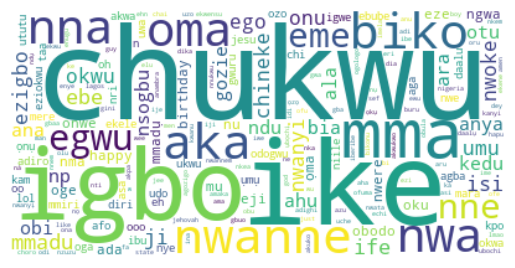

In [124]:
# create word cloud for the review body
text = " ".join([t for t in data['clean_tweet']])
word_cloud = WordCloud(stopwords = IGBO_STOPWORDS, collocations = False, background_color = 'white').generate(text)
plt.imshow(word_cloud, interpolation='bilinear')
plt.axis("off")
plt.show()

### Observation

There are emojis in the tweets. Emojis can be beneficial in determining the sentiment of a text. To test this hypothesis, the performance of different models will be tested to show how emojis can affect them.

<b> 1. Clean data with emoji as is ==> data['clean_tweet'] </b>

<b> 2. Clean data with emoji removed ==> data['tweet_without_emoji'] </b>

<b> 3. Clean data with emoji replaced with the description in English ==> data['tweet_with_emoji_replaced'] </b>

<b> 4. Clean data with emoji placed at the end of the text and replaced with the description in English ==> data['tweet_with_emoji_replaced_at_end'] </b>

In [176]:
data['clean_tweet'].head()

0                                nna ike gwuru ooo 😂
1                                   chineke nna kezi
2                        lol isi adirokwanu nma 😐😒😒😒
3    haha fulani herdsmen akpa amu retweet rie nsi 😝
4                                nna ghetto aru biko
Name: clean_tweet, dtype: object

In [178]:
# remove emojis
data['tweet_without_emoji'] = data['clean_tweet'].apply(lambda x: emoji.replace_emoji(x, replace=''))
data['tweet_without_emoji'].head()

0                                nna ike gwuru ooo 
1                                  chineke nna kezi
2                           lol isi adirokwanu nma 
3    haha fulani herdsmen akpa amu retweet rie nsi 
4                               nna ghetto aru biko
Name: tweet_without_emoji, dtype: object

In [180]:
# Replace emojis with text
data['tweet_with_emoji_replaced'] = data['clean_tweet'].apply(lambda x: emoji.demojize(x, delimiters=(' ', ' '), language='en'))
data['tweet_with_emoji_replaced'].head()

0           nna ike gwuru ooo  face_with_tears_of_joy 
1                                     chineke nna kezi
2    lol isi adirokwanu nma  neutral_face  unamused...
3    haha fulani herdsmen akpa amu retweet rie nsi ...
4                                  nna ghetto aru biko
Name: tweet_with_emoji_replaced, dtype: object

In [184]:
# Function to extract emojis from text
def extract_emojis(text):
    return ' '.join(emoji.distinct_emoji_list(text))

# Apply function to DataFrame and create new column
data['tweet_with_emoji_replaced_at_end'] = data['tweet_without_emoji'] + data['clean_tweet'].apply(extract_emojis).apply(lambda x: emoji.demojize(x, delimiters=(' ', ' '), language='en'))
data['tweet_with_emoji_replaced_at_end'].head()

0           nna ike gwuru ooo  face_with_tears_of_joy 
1                                     chineke nna kezi
2    lol isi adirokwanu nma  neutral_face   unamuse...
3    haha fulani herdsmen akpa amu retweet rie nsi ...
4                                  nna ghetto aru biko
Name: tweet_with_emoji_replaced_at_end, dtype: object

In [188]:
# fraction of reviews
data.label.value_counts()/len(data)

label
neutral     0.442034
positive    0.302834
negative    0.255132
Name: count, dtype: float64

### Vectorization

Columns must be converted to a numerical format that the ML model can understand.

In [198]:
# Encode labels
label_encoder = LabelEncoder()
data['label'] = label_encoder.fit_transform(data['label']) 
data['label'].sample(5)

8800    2
7782    2
5888    1
8980    2
3529    1
Name: label, dtype: int64

In [298]:
from sentence_transformers import SentenceTransformer

def vectorize(data,column):
    # define the vectorizer and specify the arguments, ngrams (1,3) considers unigram - one word, bigram - two consecutive words, trigram - three words 
    text = [t for t in data[column]]
    vect = TfidfVectorizer(ngram_range=(1, 3), max_features=500, token_pattern=r'\b[^\d\W][^\d\W]+\b').fit(text)
    # Transform the vectorizer
    num_txt = vect.transform(text).toarray()
 
    return num_txt

embeddings1 = vectorize(data,'clean_tweet')
embeddings2 = vectorize(data,'tweet_without_emoji')
embeddings3 = vectorize(data,'tweet_with_emoji_replaced')
embeddings4 = vectorize(data,'tweet_with_emoji_replaced_at_end')

In [249]:
# Build model and calculate the accuracy
def build(model):
    model = model().fit(X_train, y_train)

    return model
def result(model):
    # predicting and calculating accuracy
    predict = model.predict(X_test)
    # classification report
    print(classification_report(y_test,predict))
    # plot confusion matrix
    cm = confusion_matrix(y_test,predict)
    ConfusionMatrixDisplay(cm).plot()
    plt.show()

### Case 1: Texts with emojis as is

<class 'sklearn.linear_model._logistic.LogisticRegression'>
              precision    recall  f1-score   support

           0       0.75      0.57      0.65       634
           1       0.71      0.84      0.77      1063
           2       0.83      0.77      0.80       710

    accuracy                           0.75      2407
   macro avg       0.76      0.73      0.74      2407
weighted avg       0.75      0.75      0.75      2407



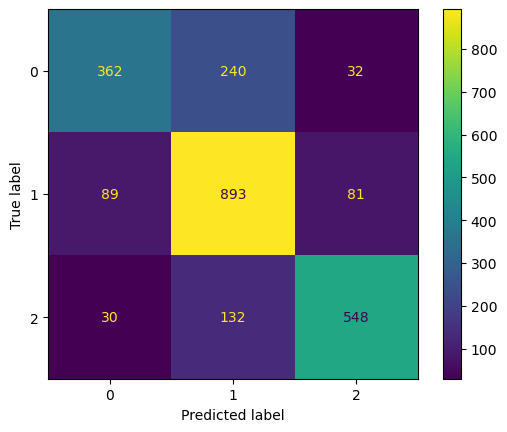

<class 'sklearn.ensemble._forest.RandomForestClassifier'>
              precision    recall  f1-score   support

           0       0.69      0.57      0.63       634
           1       0.72      0.78      0.74      1063
           2       0.77      0.79      0.78       710

    accuracy                           0.73      2407
   macro avg       0.72      0.71      0.72      2407
weighted avg       0.72      0.73      0.72      2407



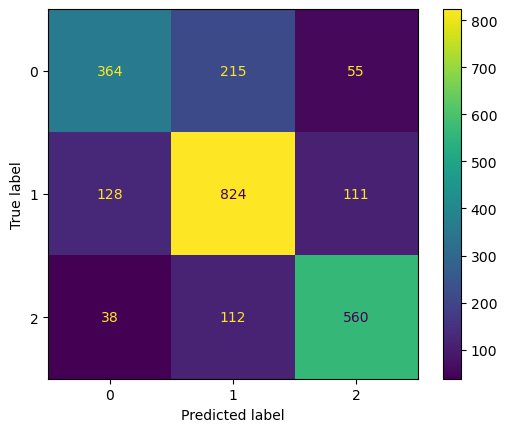

<class 'sklearn.naive_bayes.GaussianNB'>
              precision    recall  f1-score   support

           0       0.39      0.90      0.55       634
           1       0.71      0.32      0.44      1063
           2       0.87      0.58      0.70       710

    accuracy                           0.55      2407
   macro avg       0.66      0.60      0.56      2407
weighted avg       0.67      0.55      0.54      2407



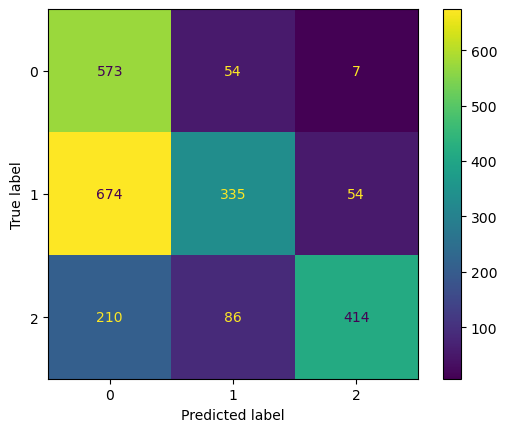

<class 'sklearn.tree._classes.DecisionTreeClassifier'>
              precision    recall  f1-score   support

           0       0.59      0.57      0.58       634
           1       0.69      0.70      0.69      1063
           2       0.76      0.76      0.76       710

    accuracy                           0.68      2407
   macro avg       0.68      0.68      0.68      2407
weighted avg       0.68      0.68      0.68      2407



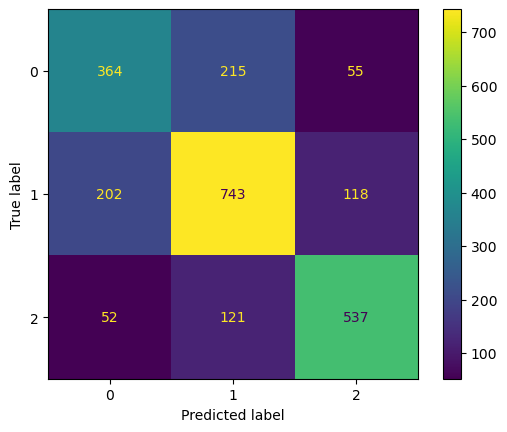

In [304]:
# define target and features
y = data.label
X_train, X_test, y_train, y_test = train_test_split(embeddings1, y, test_size = 0.2, random_state = 4)

models = [LogisticRegression,RandomForestClassifier,GaussianNB,DecisionTreeClassifier]
for m in models:
    model = build(m)
    print(m)
    result(model)

### Case 2: Texts with emojis removed

<class 'sklearn.linear_model._logistic.LogisticRegression'>
              precision    recall  f1-score   support

           0       0.75      0.58      0.65       634
           1       0.71      0.84      0.77      1063
           2       0.83      0.77      0.80       710

    accuracy                           0.75      2407
   macro avg       0.76      0.73      0.74      2407
weighted avg       0.76      0.75      0.75      2407



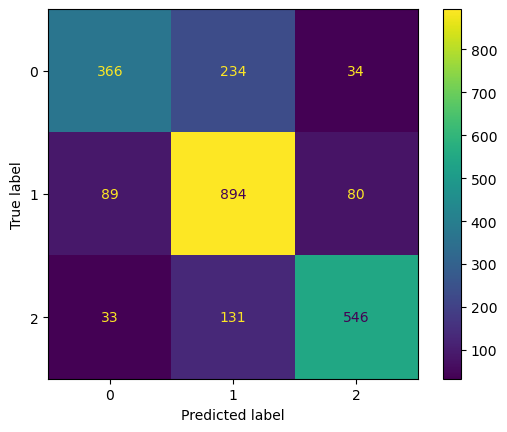

<class 'sklearn.ensemble._forest.RandomForestClassifier'>
              precision    recall  f1-score   support

           0       0.69      0.58      0.63       634
           1       0.72      0.78      0.75      1063
           2       0.78      0.79      0.78       710

    accuracy                           0.73      2407
   macro avg       0.73      0.72      0.72      2407
weighted avg       0.73      0.73      0.73      2407



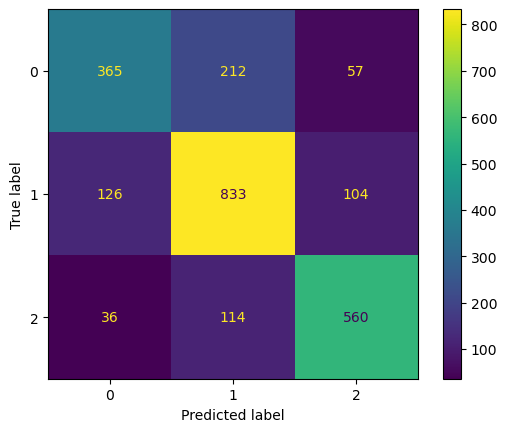

<class 'sklearn.naive_bayes.GaussianNB'>
              precision    recall  f1-score   support

           0       0.40      0.90      0.55       634
           1       0.71      0.32      0.44      1063
           2       0.87      0.59      0.70       710

    accuracy                           0.55      2407
   macro avg       0.66      0.60      0.56      2407
weighted avg       0.67      0.55      0.55      2407



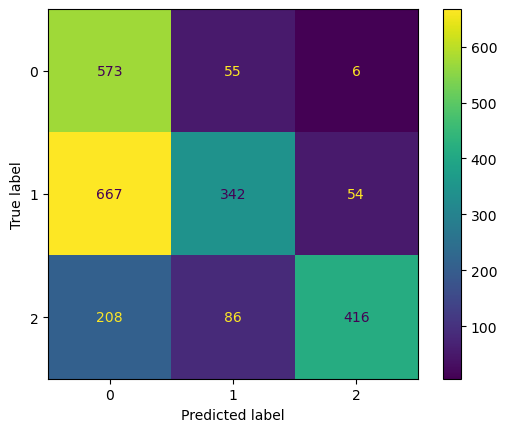

<class 'sklearn.tree._classes.DecisionTreeClassifier'>
              precision    recall  f1-score   support

           0       0.59      0.60      0.59       634
           1       0.69      0.69      0.69      1063
           2       0.75      0.75      0.75       710

    accuracy                           0.68      2407
   macro avg       0.68      0.68      0.68      2407
weighted avg       0.68      0.68      0.68      2407



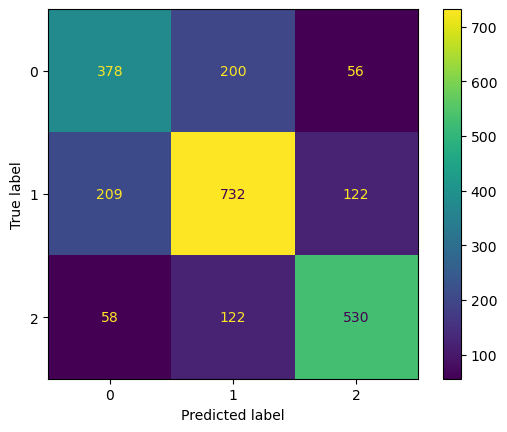

In [302]:
# define target and features
y = data.label
X_train, X_test, y_train, y_test = train_test_split(embeddings2, y, test_size = 0.2, random_state = 4)

models = [LogisticRegression,RandomForestClassifier,GaussianNB,DecisionTreeClassifier]
for m in models:
    model = build(m)
    print(m)
    result(model)

### Case 3: Texts with emojis replaced with text description

<class 'sklearn.linear_model._logistic.LogisticRegression'>
              precision    recall  f1-score   support

           0       0.70      0.59      0.64       634
           1       0.71      0.81      0.76      1063
           2       0.83      0.77      0.80       710

    accuracy                           0.74      2407
   macro avg       0.75      0.73      0.73      2407
weighted avg       0.74      0.74      0.74      2407



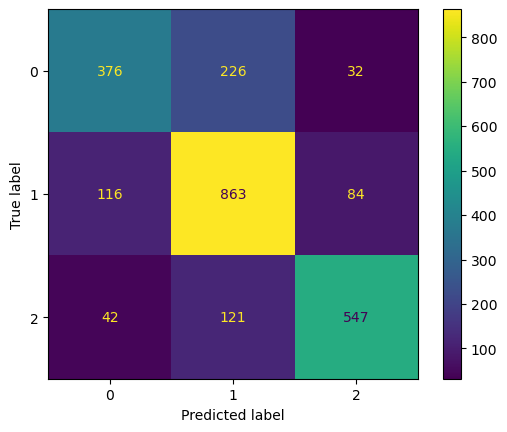

KeyboardInterrupt: 

In [307]:
# define target and features
y = data.label
X_train, X_test, y_train, y_test = train_test_split(embeddings3, y, test_size = 0.2, random_state = 4)

models = [LogisticRegression,RandomForestClassifier,GaussianNB,DecisionTreeClassifier]
for m in models:
    model = build(m)
    print(m)
    result(model)

### Case 4: Texts with emoji placed at the end and replaced with the description 

<class 'sklearn.linear_model._logistic.LogisticRegression'>
              precision    recall  f1-score   support

           0       0.74      0.59      0.66       634
           1       0.71      0.83      0.76      1063
           2       0.83      0.78      0.80       710

    accuracy                           0.75      2407
   macro avg       0.76      0.73      0.74      2407
weighted avg       0.75      0.75      0.75      2407



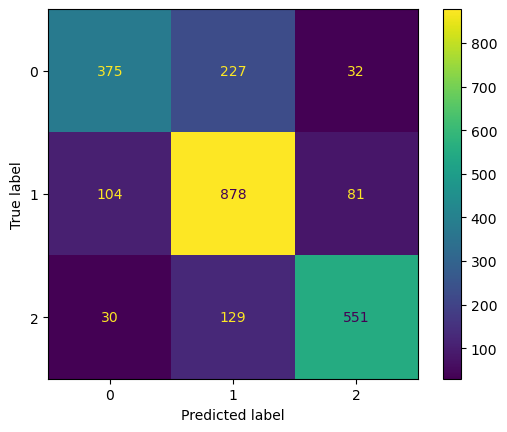

<class 'sklearn.ensemble._forest.RandomForestClassifier'>
              precision    recall  f1-score   support

           0       0.68      0.56      0.61       634
           1       0.71      0.76      0.74      1063
           2       0.77      0.81      0.79       710

    accuracy                           0.72      2407
   macro avg       0.72      0.71      0.71      2407
weighted avg       0.72      0.72      0.72      2407



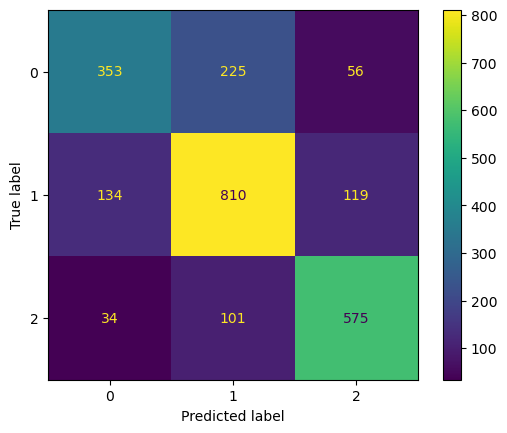

<class 'sklearn.naive_bayes.GaussianNB'>
              precision    recall  f1-score   support

           0       0.41      0.91      0.56       634
           1       0.73      0.35      0.47      1063
           2       0.85      0.59      0.70       710

    accuracy                           0.57      2407
   macro avg       0.66      0.62      0.58      2407
weighted avg       0.68      0.57      0.56      2407



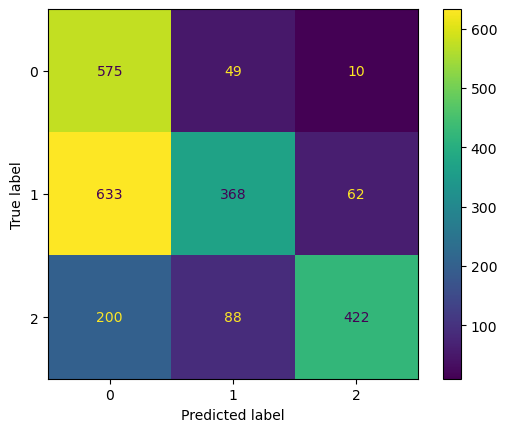

<class 'sklearn.tree._classes.DecisionTreeClassifier'>
              precision    recall  f1-score   support

           0       0.60      0.59      0.59       634
           1       0.69      0.67      0.68      1063
           2       0.73      0.77      0.75       710

    accuracy                           0.68      2407
   macro avg       0.67      0.68      0.67      2407
weighted avg       0.68      0.68      0.68      2407



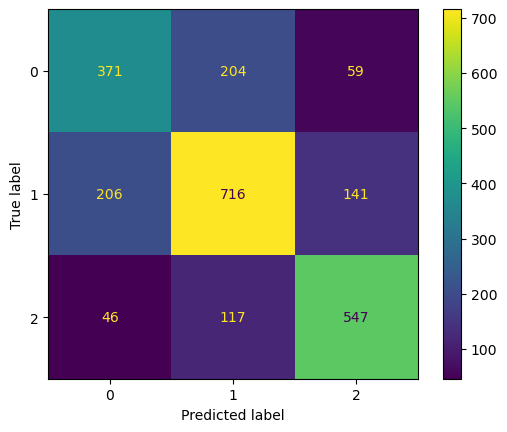

In [310]:
# define target and features
y = data.label
X_train, X_test, y_train, y_test = train_test_split(embeddings4, y, test_size = 0.2, random_state = 4)

models = [LogisticRegression,RandomForestClassifier,GaussianNB,DecisionTreeClassifier]
for m in models:
    model = build(m)
    print(m)
    result(model)

### Deep Learning

In [327]:
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.utils import plot_model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (
    Input,
    Conv2D, 
    Activation, 
    BatchNormalization, 
    MaxPooling2D, 
    Dropout, 
    Flatten, 
    Dense
)
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler,EarlyStopping,TensorBoard,ReduceLROnPlateau

In [353]:
from tensorflow.keras.utils import to_categorical
num_classes = 3
y = to_categorical(data['label'], num_classes=num_classes)
print(y.shape)

(12033, 3)


### Case 1

In [411]:
X_train, X_temp, y_train, y_temp = train_test_split(embeddings1, y, test_size=0.3, random_state=4)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=4)

In [433]:
# Initiating model on CPU
def build():
    model = Sequential()
    model.add(Input(shape = (X_train.shape[1],)))
    
    model.add(Dense(256))
    model.add(Activation('relu'))# Activation function
    model.add(Dropout(0.2))

    model.add(Dense(128))
    model.add(Activation('relu'))
    model.add(Dropout(0.2))

    model.add(Dense(64))
    model.add(Activation('relu'))
    model.add(Dropout(0.5))

    model.add(Dense(32))
    model.add(Activation('relu'))
    model.add(Dropout(0.5))

    # Output Layer
    model.add(Dense(3, activation = 'softmax')) # multiClassification layer
    return model

In [435]:
model = build()

In [437]:
# Compiling model
model.compile(optimizer = 'adam',
              loss = 'binary_crossentropy', # change to sparse_categorical_crossentropy for multiclass where each sample can only belong to one class
              metrics = ['accuracy']) # Evaluation metric

In [439]:
# Defining an Early Stopping and Model Checkpoints
early_stopping = EarlyStopping(monitor = 'val_loss', 
                               min_delta = 0.01,
                               mode = 'min',
                               patience = 7,
                               start_from_epoch = 10,
                              restore_best_weights = True)

checkpoint = ModelCheckpoint('best_model.keras',
                            monitor = 'val_loss',
                            save_best_only = True)

In [441]:
model.fit(X_train, y_train, epochs=20, batch_size=64, verbose=  1, validation_data = (X_val, y_val), callbacks=[checkpoint, early_stopping])

Epoch 1/20
132/132 ━━━━━━━━━━━━━━━━━━━━ 7s 19ms/step - accuracy: 0.4186 - loss: 0.6532 - val_accuracy: 0.6493 - val_loss: 0.4956
Epoch 2/20
132/132 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - accuracy: 0.6644 - loss: 0.4821 - val_accuracy: 0.7224 - val_loss: 0.4089
Epoch 3/20
132/132 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - accuracy: 0.7600 - loss: 0.3883 - val_accuracy: 0.7213 - val_loss: 0.4087
Epoch 4/20
132/132 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step - accuracy: 0.7778 - loss: 0.3607 - val_accuracy: 0.7319 - val_loss: 0.4126
Epoch 5/20
132/132 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - accuracy: 0.8043 - loss: 0.3290 - val_accuracy: 0.7324 - val_loss: 0.4247
Epoch 6/20
132/132 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.8173 - loss: 0.3023 - val_accuracy: 0.7263 - val_loss: 0.4301
Epoch 7/20
132/132 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - accuracy: 0.8336 - loss: 0.2792 - val_accuracy: 0.7097 - val_loss: 0.4651
Epoch 8/20
132/132 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - accuracy: 0.8535 - loss: 0.2496 - val_accu

In [443]:
# Load the best model
best_model = tf.keras.models.load_model('best_model1.keras')

In [445]:
best_model.evaluate(X_test, y_test, batch_size=64, verbose=1) 

29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.7463 - loss: 0.3871


[0.39288660883903503, 0.7379501461982727]

### Case 2

In [450]:
X_train, X_temp, y_train, y_temp = train_test_split(embeddings2, y, test_size=0.3, random_state=4)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=4)


In [452]:
# Defining an Early Stopping and Model Checkpoints
early_stopping = EarlyStopping(monitor = 'val_loss', 
                               min_delta = 0.01,
                               mode = 'min',
                               patience = 7,
                               start_from_epoch = 10,
                              restore_best_weights = True)

checkpoint = ModelCheckpoint('best_model2.keras',
                            monitor = 'val_loss',
                            save_best_only = True)

In [454]:
model.fit(X_train, y_train, epochs=20, batch_size=64, verbose=  1, validation_data = (X_val, y_val), callbacks=[checkpoint, early_stopping])

Epoch 1/20
132/132 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - accuracy: 0.5684 - loss: 0.7074 - val_accuracy: 0.6837 - val_loss: 0.4498
Epoch 2/20
132/132 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - accuracy: 0.7159 - loss: 0.4179 - val_accuracy: 0.7130 - val_loss: 0.4192
Epoch 3/20
132/132 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - accuracy: 0.7803 - loss: 0.3430 - val_accuracy: 0.7202 - val_loss: 0.4310
Epoch 4/20
132/132 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - accuracy: 0.8130 - loss: 0.3061 - val_accuracy: 0.7296 - val_loss: 0.4554
Epoch 5/20
132/132 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - accuracy: 0.8348 - loss: 0.2664 - val_accuracy: 0.7191 - val_loss: 0.4652
Epoch 6/20
132/132 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step - accuracy: 0.8493 - loss: 0.2446 - val_accuracy: 0.7136 - val_loss: 0.5042
Epoch 7/20
132/132 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - accuracy: 0.8558 - loss: 0.2333 - val_accuracy: 0.7158 - val_loss: 0.5465
Epoch 8/20
132/132 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - accuracy: 0.8667 - loss: 0.2144 - val_accu

In [458]:
# Load the best model
best_model = tf.keras.models.load_model('best_model2.keras')
best_model.evaluate(X_test, y_test, batch_size=64, verbose=1) 

29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.7371 - loss: 0.4092


[0.41120630502700806, 0.7290858626365662]

### Case 3

In [460]:
X_train, X_temp, y_train, y_temp = train_test_split(embeddings2, y, test_size=0.3, random_state=4)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=4)
# Defining an Early Stopping and Model Checkpoints
early_stopping = EarlyStopping(monitor = 'val_loss', 
                               min_delta = 0.01,
                               mode = 'min',
                               patience = 7,
                               start_from_epoch = 10,
                              restore_best_weights = True)

checkpoint = ModelCheckpoint('best_model3.keras',
                            monitor = 'val_loss',
                            save_best_only = True)
model.fit(X_train, y_train, epochs=20, batch_size=64, verbose=  1, validation_data = (X_val, y_val), callbacks=[checkpoint, early_stopping])

Epoch 1/20
132/132 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step - accuracy: 0.8952 - loss: 0.1645 - val_accuracy: 0.7047 - val_loss: 0.7630
Epoch 2/20
132/132 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step - accuracy: 0.8998 - loss: 0.1538 - val_accuracy: 0.7030 - val_loss: 0.7317
Epoch 3/20
132/132 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step - accuracy: 0.9014 - loss: 0.1556 - val_accuracy: 0.6842 - val_loss: 0.8312
Epoch 4/20
132/132 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - accuracy: 0.9040 - loss: 0.1545 - val_accuracy: 0.7075 - val_loss: 0.8614
Epoch 5/20
132/132 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step - accuracy: 0.9146 - loss: 0.1340 - val_accuracy: 0.7119 - val_loss: 0.8285
Epoch 6/20
132/132 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - accuracy: 0.9046 - loss: 0.1370 - val_accuracy: 0.7180 - val_loss: 0.9069
Epoch 7/20
132/132 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step - accuracy: 0.9133 - loss: 0.1237 - val_accuracy: 0.7169 - val_loss: 0.9560
Epoch 8/20
132/132 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.9113 - loss: 0.1310 - val_accu

In [465]:
# Load the best model
best_model = tf.keras.models.load_model('best_model3.keras')
best_model.evaluate(X_test, y_test, batch_size=64, verbose=1) 

29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.7117 - loss: 0.7131


[0.710284411907196, 0.7063711881637573]

### Case 4

In [467]:
X_train, X_temp, y_train, y_temp = train_test_split(embeddings2, y, test_size=0.3, random_state=4)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=4)
# Defining an Early Stopping and Model Checkpoints
early_stopping = EarlyStopping(monitor = 'val_loss', 
                               min_delta = 0.01,
                               mode = 'min',
                               patience = 7,
                               start_from_epoch = 10,
                              restore_best_weights = True)

checkpoint = ModelCheckpoint('best_model4.keras',
                            monitor = 'val_loss',
                            save_best_only = True)
model.fit(X_train, y_train, epochs=20, batch_size=64, verbose=  1, validation_data = (X_val, y_val), callbacks=[checkpoint, early_stopping])

Epoch 1/20
132/132 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - accuracy: 0.9129 - loss: 0.1268 - val_accuracy: 0.7202 - val_loss: 1.0092
Epoch 2/20
132/132 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.9224 - loss: 0.1098 - val_accuracy: 0.7219 - val_loss: 1.1254
Epoch 3/20
132/132 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.9233 - loss: 0.1121 - val_accuracy: 0.7219 - val_loss: 1.0570
Epoch 4/20
132/132 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.9190 - loss: 0.1137 - val_accuracy: 0.7191 - val_loss: 1.1977
Epoch 5/20
132/132 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.9250 - loss: 0.1120 - val_accuracy: 0.7097 - val_loss: 1.1229
Epoch 6/20
132/132 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.9225 - loss: 0.1118 - val_accuracy: 0.7069 - val_loss: 1.1091
Epoch 7/20
132/132 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.9172 - loss: 0.1196 - val_accuracy: 0.7141 - val_loss: 1.1450
Epoch 8/20
132/132 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.9200 - loss: 0.1099 - val_accu

In [468]:
# Load the best model
best_model = tf.keras.models.load_model('best_model4.keras')
best_model.evaluate(X_test, y_test, batch_size=64, verbose=1) 

29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.7303 - loss: 0.9728


[0.9642347693443298, 0.7268698215484619]

### FineTune BERT Model